In [41]:
## compass_initalizations_terminal.jl
#using Plots
using CairoMakie
using RollingFunctions
using ProgressMeter
using LinearAlgebra
using DelaunayTriangulation
using DelimitedFiles
using MPI
include("Compass.jl")

#tried all Z measurements but did not work
function Zs(N)
    Xarr = falses(N)
    Zarr = trues(N)
    return PauliOperator(0x00, Xarr, Zarr)
end

function Y_line(L)
    N = L^2
    Xarr = falses(N)
    Zarr = falses(N)
    for i in 1:L
        Xarr[i] = true
        Zarr[i] = true
    end
    return PauliOperator(0x00, Xarr, Zarr)
end

function initialize_state(L; method="prepared")
    if method == "prepared"
        N = L^2

        state = MixedDestabilizer(zero(Stabilizer, L^2))
        x, y, z = create_operators(L)
        yl = Y_line(L)
        zs = Zs(N)
        
        println(QuantumClifford.trusted_rank(state))

        #project all XX operators
        for i in 1:L
            for j in 1:L
                project!(state, x[i, j]; keep_result=false, phases=false)
            end
        end
        println(QuantumClifford.trusted_rank(state))
        #project all YY operators
        for k in 1:L
            for l in 1:L
                project!(state, y[k, l]; keep_result=false, phases=false)
            end
        end
        println(QuantumClifford.trusted_rank(state))

        #project a line of Y operators
        #project!(state, yl)
        project!(state,yl)
        println(QuantumClifford.trusted_rank(state))

        #if not full rank, throw an error
        if QuantumClifford.trusted_rank(state) != N
            error("Rank is not N")
        end

        return state
    elseif method == "mixed"
        return MixedDestabilizer(one(Stabilizer, L^2))
    elseif method == "zero"
        return MixedDestabilizer(zero(Stabilizer, L^2))
    else 
        error("Invalid method")
    end
end
Stabilizer(one(Stabilizer, 16))


function main2(p, L; initialize = "mixed", checkrank = false, keep_result=false, phases=false, iterations = 2000, thermalization = 500, between_measurements = 200) 
    X,Y,Z = create_operators(L)
    N = L^2
    dist  = Distributions.Categorical([p[1],p[2],p[3]])
    Sx = []
    # Sy = []
    Tx = []
    # Ty = []
    r = []

    #if initialize == "mixed"
    #    state = MixedDestabilizer(one(Stabilizer, N))
    #elseif initialize == "zero"
    #    state = MixedDestabilizer(zero(Stabilizer, N))
    #end

    state = initialize_state(L, method=initialize)

    
    #for i in length(X)
    #    project!(state, X[i], keep_result=false, phases=false)
    #end

    for i in 1:thermalization
        for j in 1:N
            xi = rand(1:L)
            yi = rand(1:L)

            ope = rand(dist)

            if ope == 1 #do X operation
                project!(state, X[xi,yi], keep_result=keep_result, phases=phases)
            elseif ope == 2 #do Y operation
                project!(state, Y[xi,yi], keep_result=keep_result, phases=phases)
            else #do Z operation
                yi = rand(1:Int(L/2))
                project!(state, Z[xi,yi], keep_result=keep_result, phases=phases)
            end
        end
        if checkrank == true
            push!(r, QuantumClifford.trusted_rank(state))
        end
        #if check == true
        #    println("trusted Rank = ", QuantumClifford.trusted_rank(state))
        #end
    end

    for _ in 1:iterations
        for _ in 1:N
            xi = rand(1:L)
            yi = rand(1:L)

            ope = rand(dist)

            if ope == 1 #do X operation
                project!(state, X[xi,yi], keep_result=false, phases=false)
            elseif ope == 2 #do Y operation
                project!(state, Y[xi,yi], keep_result=false, phases=false)
            else #do Z operation
                yi = rand(1:Int(L/2))
                project!(state, Z[xi,yi], keep_result=false, phases=false)
            end
        end
        push!(Sx, calc_EE(state, 1:Int(L/2), L, "x"))
        # push!(Sy, calc_EE(state, 1:Int(L/2), L, "y"))
        push!(Tx, TMI(state, L, "x"))
        # push!(Ty, TMI(state, L, "y"))
        push!(r, QuantumClifford.trusted_rank(state))
        # for _ in 1:between_measurements
        #     for _ in 1:N
        #         xi = rand(1:L)
        #         yi = rand(1:L)

        #         ope = rand(dist)

        #         if ope == 1 #do X operation
        #             project!(state, X[xi,yi], keep_result=false, phases=false)
        #         elseif ope == 2 #do Y operation
        #             project!(state, Y[xi,yi], keep_result=false, phases=false)
        #         else #do Z operation
        #             yi = rand(1:Int(L/2))
        #             project!(state, Z[xi,yi], keep_result=false, phases=false)
        #         end
        #     end
        # end
        GC.gc()
    end
    #println(QuantumClifford.trusted_rank(state))
    return Sx,Tx, r#, state
end

main2 (generic function with 1 method)

In [101]:
## calculate averages of multiple observables
L = 12
method = "mixed"
thermalization = 0
iterations = 20000
between_measurements = 0
Sx_avg = []
Sy_avg = []
Tx_avg = []
Ty_avg = []
r_avg = []
Sx_var = []
Sy_var = []
Tx_var = []
Ty_var = []
r_var = []

px = 0.5:0.05:1 #1:-0.01:0
py = 1 .-px
pz = 0.0

 @showprogress  for (i,p) in enumerate(px)
    Sx, Tx, r = main2([p, 1-p, pz], L; initialize = method, checkrank = false, iterations = iterations, thermalization = thermalization, between_measurements = between_measurements)
    open("data/thermaliztion_3_$p.txt", "a") do io
        writedlm(io, [Sx, Tx, r])
    end
 end

In [55]:
data_55 = readdlm("data/thermaliztion_0.55.txt")
data_60 = readdlm("data/thermaliztion_0.6.txt")
data_65 = readdlm("data/thermaliztion_0.65.txt")
data_70 = readdlm("data/thermaliztion_0.7.txt")
data_75 = readdlm("data/thermaliztion_0.75.txt")
data_80 = readdlm("data/thermaliztion_0.8.txt")
data_85 = readdlm("data/thermaliztion_0.85.txt")
data_90 = readdlm("data/thermaliztion_0.9.txt")
data_95 = readdlm("data/thermaliztion_0.95.txt")
data_100 = readdlm("data/thermaliztion_1.0.txt")


3×2000 Matrix{Float64}:
  14.0   15.0   12.0   12.0   12.0  …   12.0   12.0   12.0   12.0   12.0
   1.0    8.0   11.0   12.0   12.0      12.0   12.0   12.0   12.0   12.0
 144.0  144.0  144.0  144.0  144.0     144.0  144.0  144.0  144.0  144.0

In [84]:
data_2_55 = readdlm("data/thermaliztion_2_0.55.txt")
data_2_60 = readdlm("data/thermaliztion_2_0.6.txt")
data_2_65 = readdlm("data/thermaliztion_2_0.65.txt")
data_2_70 = readdlm("data/thermaliztion_2_0.7.txt")
data_2_75 = readdlm("data/thermaliztion_2_0.75.txt")
data_2_80 = readdlm("data/thermaliztion_2_0.8.txt")
data_2_85 = readdlm("data/thermaliztion_2_0.85.txt")
data_2_90 = readdlm("data/thermaliztion_2_0.9.txt")
data_2_95 = readdlm("data/thermaliztion_2_0.95.txt")
data_2_100 = readdlm("data/thermaliztion_2_1.0.txt")

3×10000 Matrix{Float64}:
  12.0   13.0   12.0   12.0   12.0  …   12.0   12.0   12.0   12.0   12.0
   2.0    8.0   12.0   12.0   12.0      12.0   12.0   12.0   12.0   12.0
 144.0  144.0  144.0  144.0  144.0     144.0  144.0  144.0  144.0  144.0

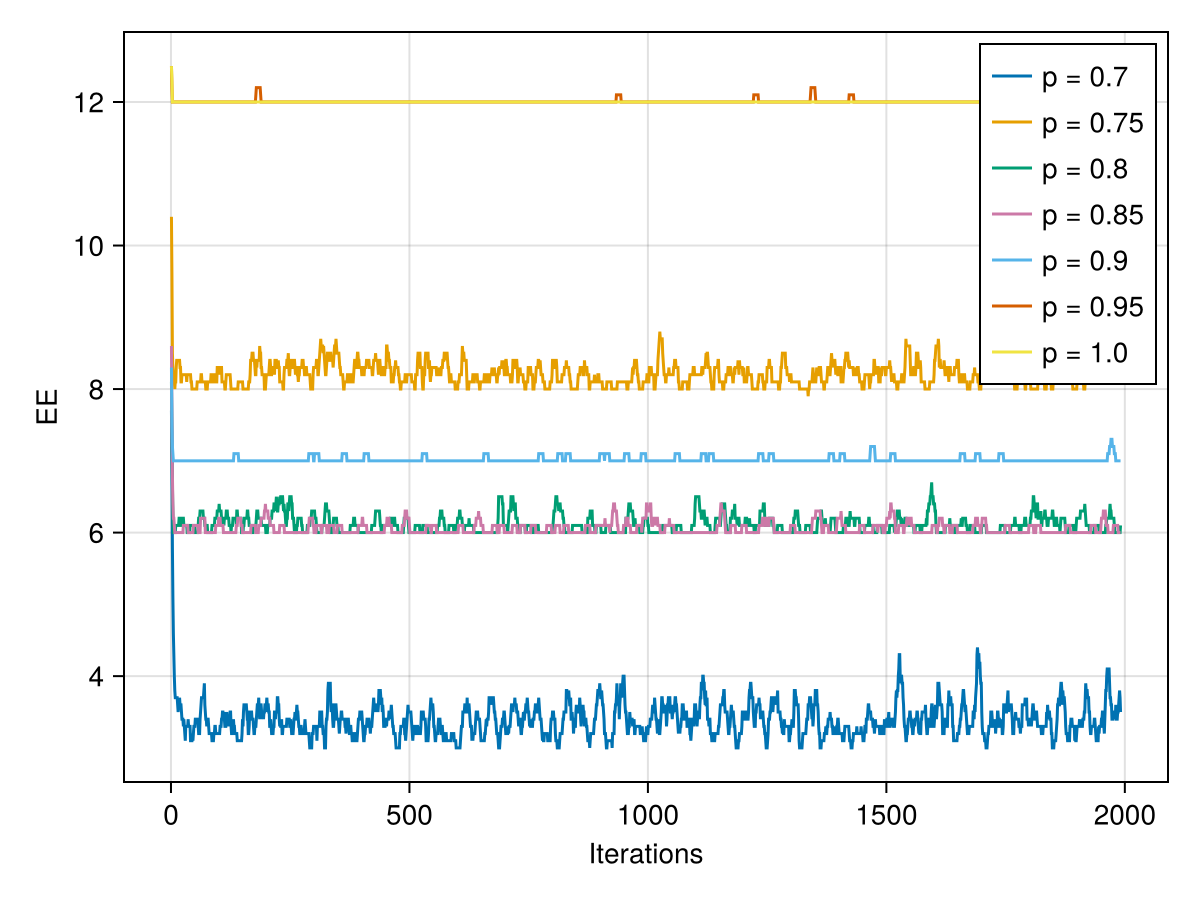

In [100]:
rm = 10
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Iterations", ylabel = "EE")
# ax2 = Axis(fig[1, 2], xlabel = "Iterations", ylabel = "TMI")

# lines!(ax, rollmean(data_55[1,:], rm),  label = "p = 0.55")
# lines!(ax, rollmean(data_60[1,:], rm),  label = "p = 0.6")
# lines!(ax, rollmean(data_65[1,:], rm),  label = "p = 0.65")
lines!(ax, rollmean(data_70[1,:], rm),  label = "p = 0.7")
lines!(ax, rollmean(data_75[1,:], rm),  label = "p = 0.75")
lines!(ax, rollmean(data_80[1,:], rm),  label = "p = 0.8")
lines!(ax, rollmean(data_85[1,:], rm),  label = "p = 0.85")
lines!(ax, rollmean(data_90[1,:], rm),  label = "p = 0.9")
lines!(ax, rollmean(data_95[1,:], rm),  label = "p = 0.95")
lines!(ax, rollmean(data_100[1,:], rm),  label = "p = 1.0")

# lines!(ax2, data_55[2,:], color = :blue, label = "p = 0.55")
# lines!(ax2, data_60[2,:], color = :red, label = "p = 0.6")
# lines!(ax2, data_65[2,:], color = :green, label = "p = 0.65")
# lines!(ax2, data_70[2,:], color = :yellow, label = "p = 0.7")   
# lines!(ax2, data_75[2,:], color = :purple, label = "p = 0.75")
# lines!(ax2, data_80[2,:], color = :orange, label = "p = 0.8")
# lines!(ax2, data_85[2,:], color = :black, label = "p = 0.85")
# lines!(ax2, data_90[2,:], color = :cyan, label = "p = 0.9")
# lines!(ax2, data_95[2,:], color = :magenta, label = "p = 0.95")
# lines!(ax2, data_100[2,:], color = :brown, label = "p = 1.0")

axislegend(ax, position = :rt)
fig

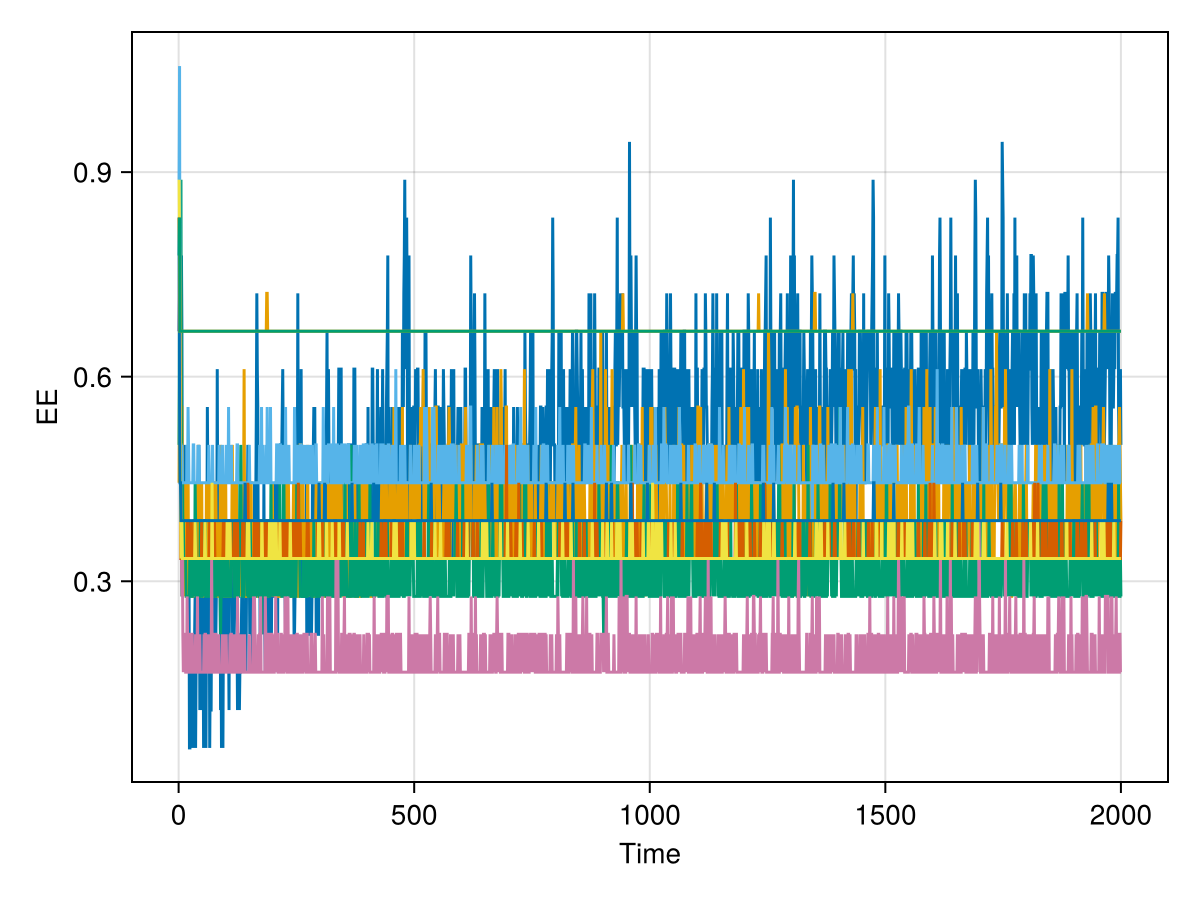

In [66]:
fig  = Figure()
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "EE")
lines!(ax,data_55[1,:]./18)
lines!(ax,data_60[1,:]./18)
lines!(ax,data_65[1,:]./18)
lines!(ax,data_70[1,:]./18)
lines!(ax,data_75[1,:]./18)
lines!(ax,data_80[1,:]./18)
lines!(ax,data_85[1,:]./18)
lines!(ax,data_90[1,:]./18)
lines!(ax,data_95[1,:]./18)
lines!(ax,data_100[1,:]./18)

fig

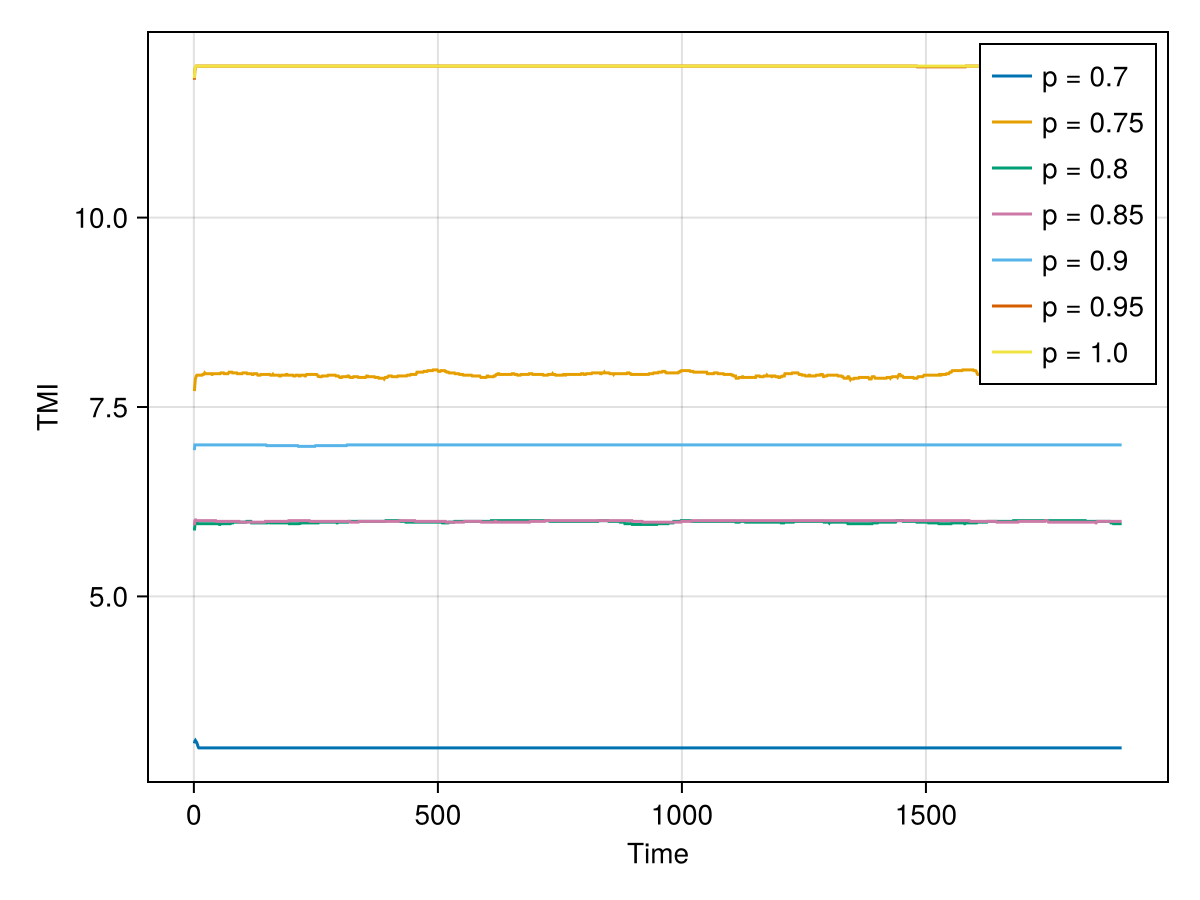

In [99]:
rm = 100
fig  = Figure()
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "TMI")
# lines!(ax,rollmean(data_55[2,:], rm), label = "p = 0.55")
# lines!(ax,rollmean(data_60[2,:], rm), label = "p = 0.6")
# lines!(ax,rollmean(data_65[2,:], rm), label = "p = 0.65")
lines!(ax,rollmean(data_70[2,:], rm), label = "p = 0.7")
lines!(ax,rollmean(data_75[2,:], rm), label = "p = 0.75")
lines!(ax,rollmean(data_80[2,:], rm), label = "p = 0.8")
lines!(ax,rollmean(data_85[2,:], rm), label = "p = 0.85")
lines!(ax,rollmean(data_90[2,:], rm), label = "p = 0.9")
lines!(ax,rollmean(data_95[2,:], rm), label = "p = 0.95")
lines!(ax,rollmean(data_100[2,:], rm), label = "p = 1.0")

axislegend(ax)
fig

In [93]:
means = [mean(data_55[2,1500:end]), mean(data_60[2,1500:end]), mean(data_65[2,1500:end]), mean(data_70[2,1500:end]), mean(data_75[2,1500:end]), mean(data_80[2,1500:end]), mean(data_85[2,1500:end]), mean(data_90[2,1500:end]), mean(data_95[2,1500:end]), mean(data_100[2,1500:end])]
means_2 = [mean(data_2_55[2,1500:end]), mean(data_2_60[2,1500:end]), mean(data_2_65[2,1500:end]), mean(data_2_70[2,1500:end]), mean(data_2_75[2,1500:end]), mean(data_2_80[2,1500:end]), mean(data_2_85[2,1500:end]), mean(data_2_90[2,1500:end]), mean(data_2_95[2,1500:end]), mean(data_2_100[2,1500:end])]

10-element Vector{Float64}:
  7.374426538054347
  6.218797788495471
  5.705446418068463
  4.94118339018939
  5.963298435478179
  6.984001882131514
  7.993294906481591
 10.99529467121515
  9.999882366780378
 12.0

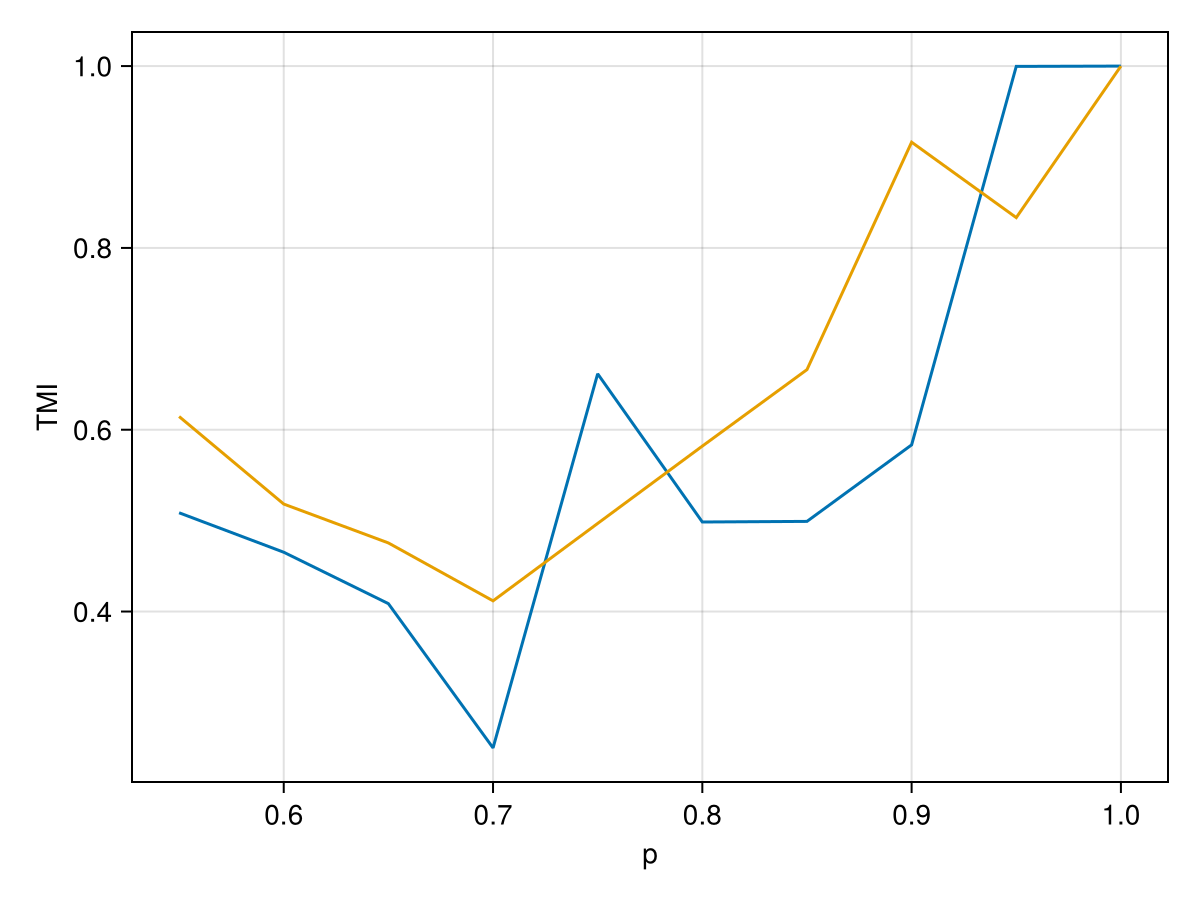

In [95]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "p", ylabel = "TMI")
lines!(0.55:0.05:1, means./12)
lines!(0.55:0.05:1, means_2./12)
fig

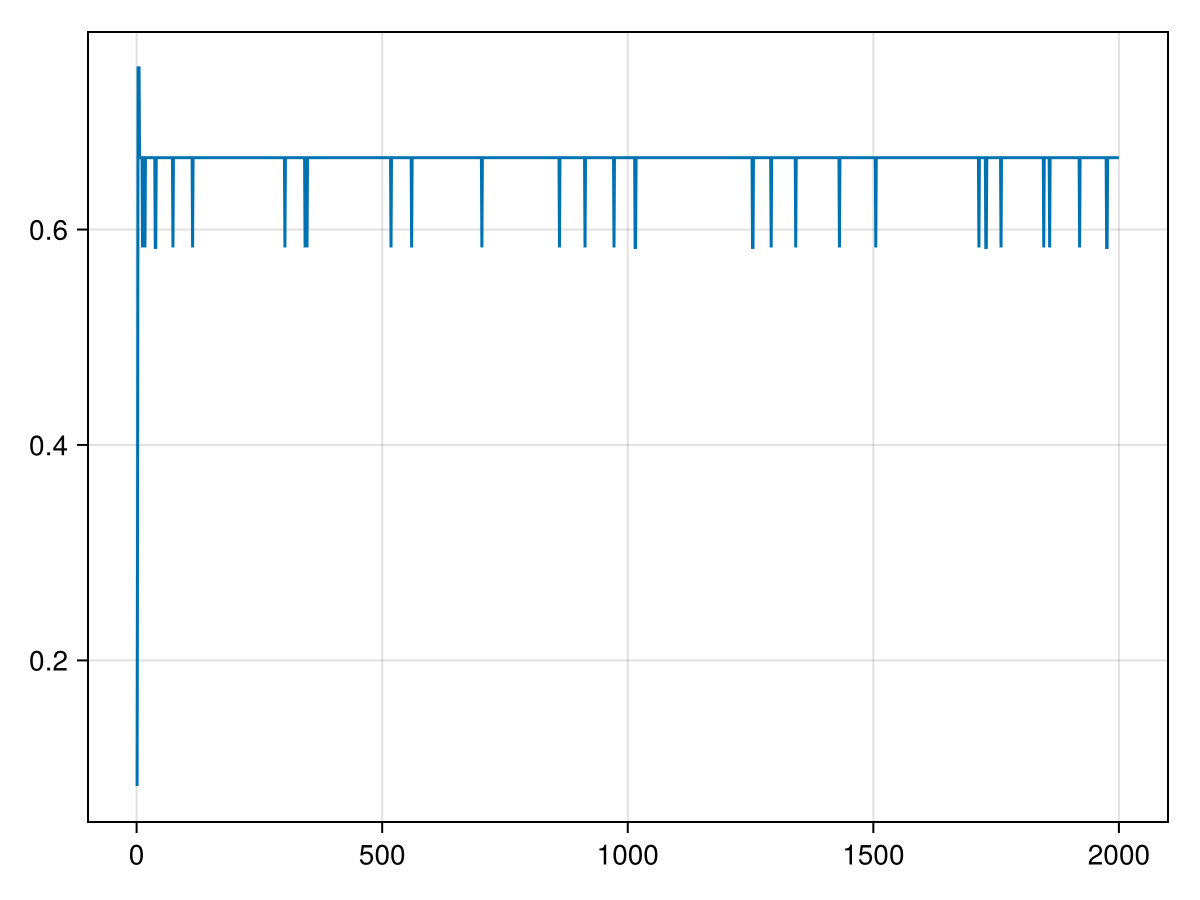

In [40]:
lines(rollmean(Tx./12, 1), label="Sx")

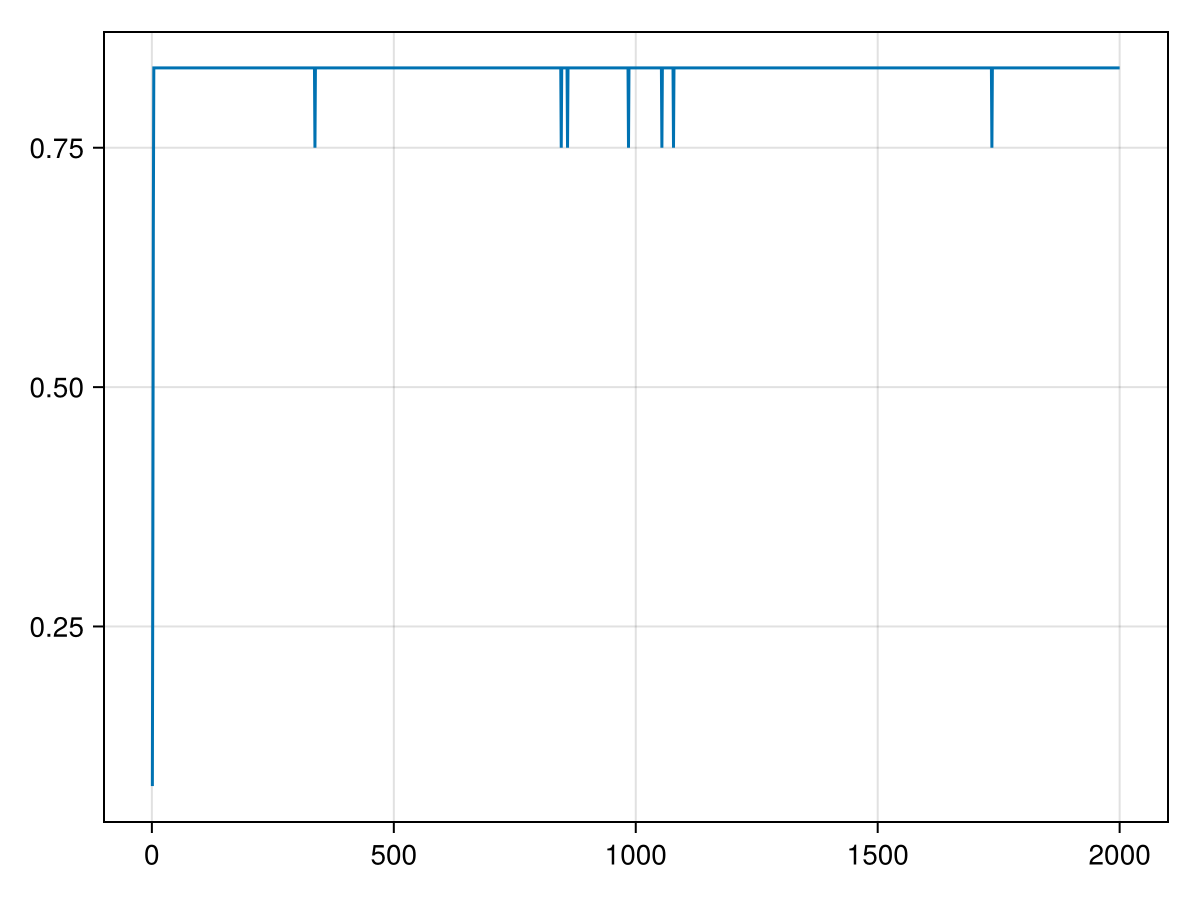

In [38]:
lines(rollmean(Tx./12, 1), label="Sx")

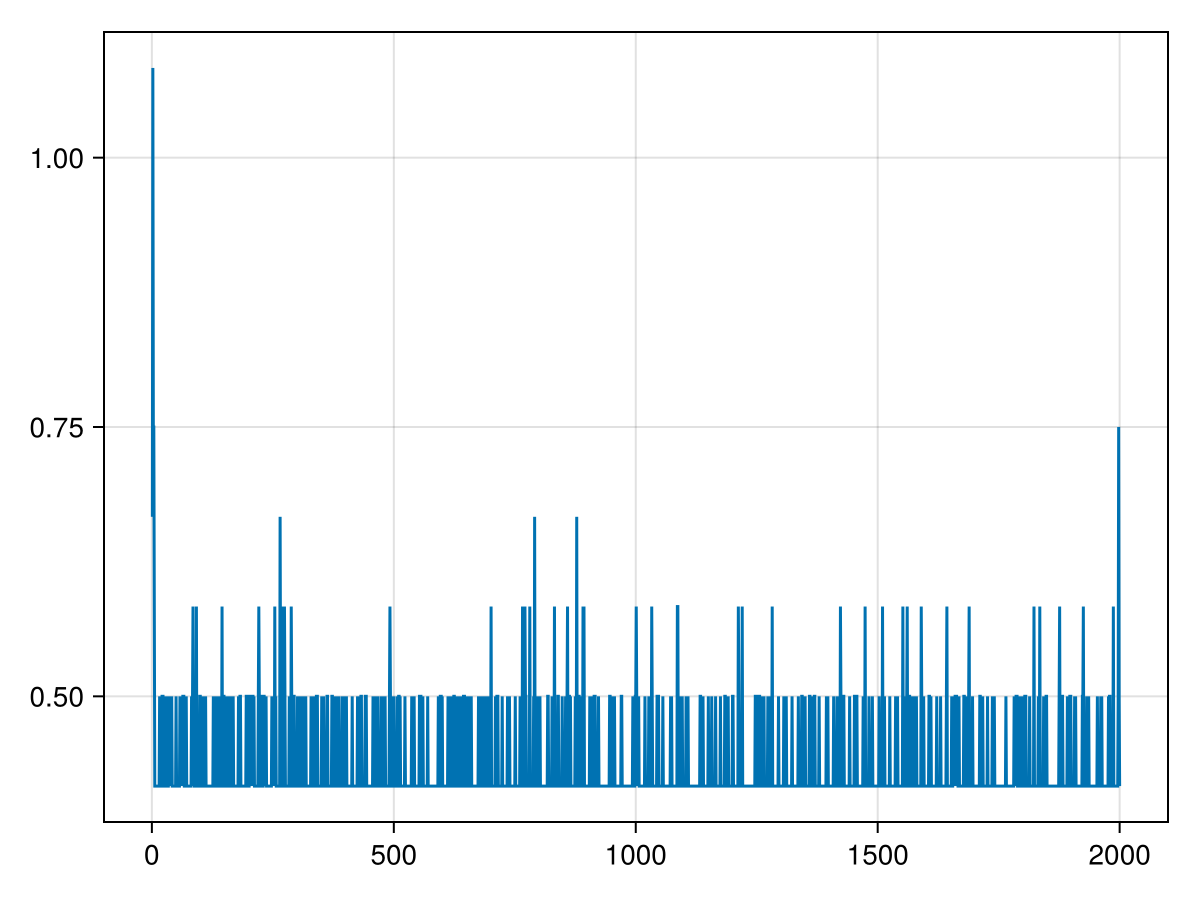

In [22]:
lines(rollmean(Sx./12,1))

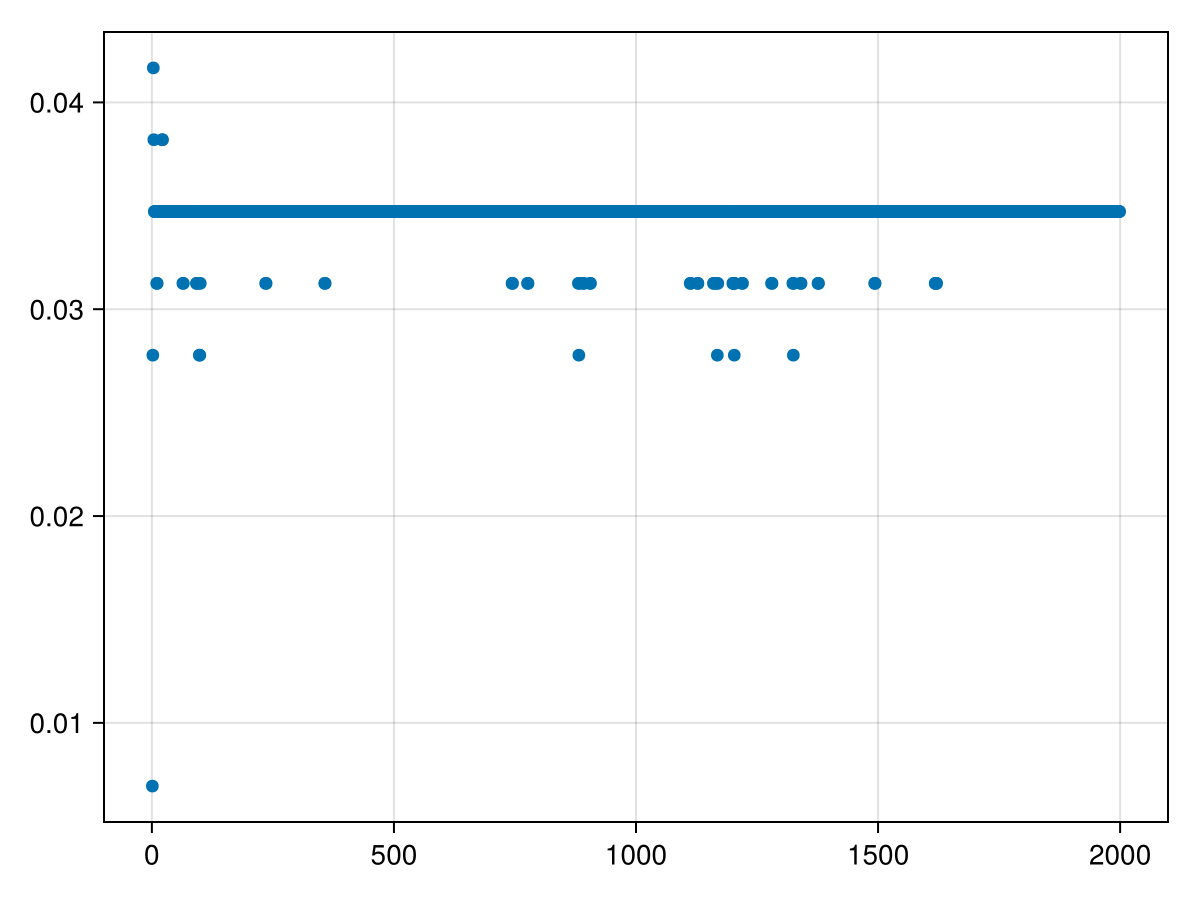

In [28]:
plot(rollmean(Tx/12^2,2))

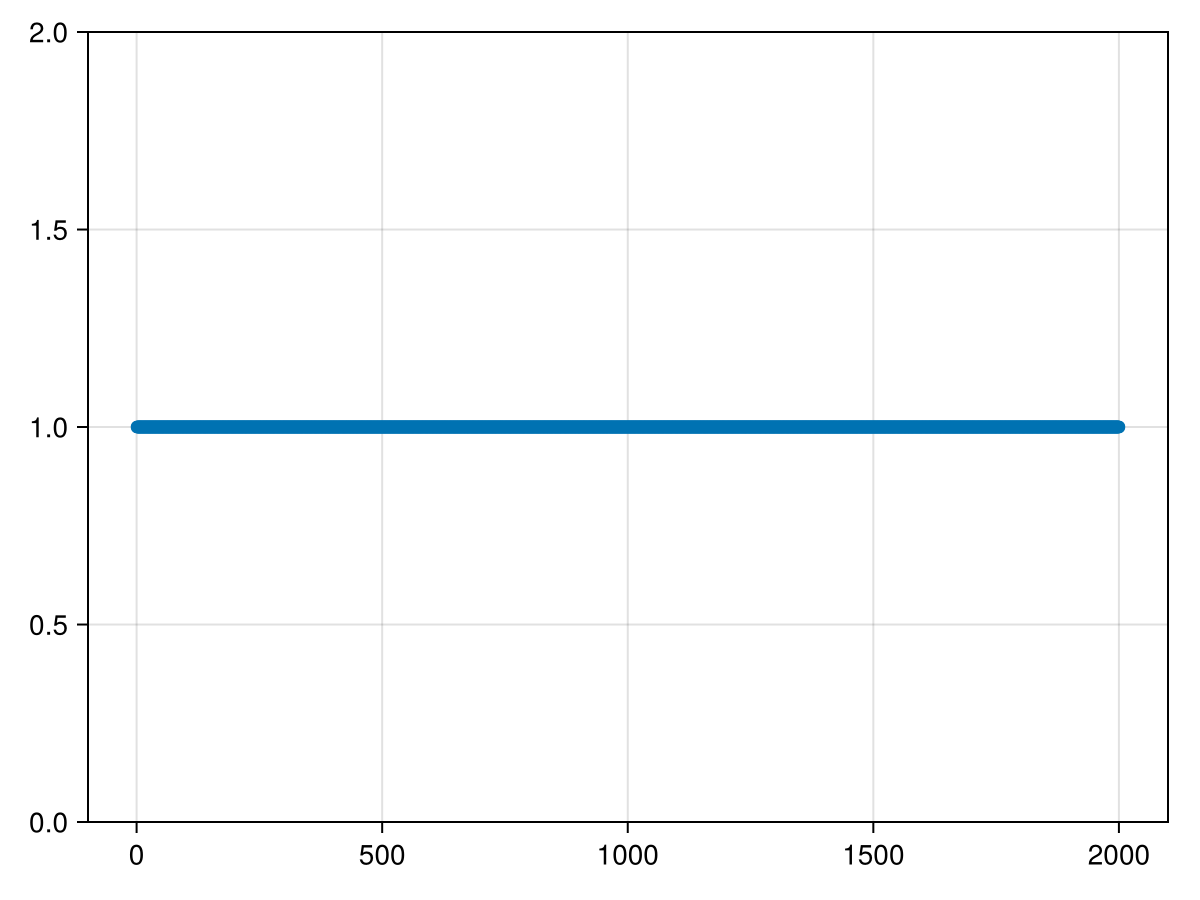

In [27]:
plot(rollmean(r./12^2,1))

In [10]:
using RollingFunctions